# Simple linear regression and Cross-validation on salary data
 

## 1. Introduction

This project uses the csv file `salary.csv` to predict employee salaries based on different employee characteristics. This will be done using linear regression. A simple model will be built to determine how well the number of years an employee has worked predicts an employee’s salary.

### 1.1 Importing modules

To accomplish this the following libraries will be imported 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 1.2 Reading CSV file into a dataframe

The next step is reading the data from the csv file into a dataframe

In [2]:
salary_df = pd.read_csv("../data/salary.csv")
salary_df.info()
salary_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary       513 non-null    float64
 1   exprior      514 non-null    int64  
 2   yearsworked  514 non-null    int64  
 3   yearsrank    514 non-null    int64  
 4   market       514 non-null    float64
 5   degree       514 non-null    int64  
 6   otherqual    514 non-null    int64  
 7   position     514 non-null    int64  
 8   male         514 non-null    int64  
 9   Field        514 non-null    int64  
 10  yearsabs     514 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 44.3 KB


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


From the table above, 11 columns consist of both int and float types, with 514 rows of data. 

The dataframe will be checked for any duplicates before it will be split into training and testing data

In [3]:
salary_df.duplicated().sum().any()

False

There are 0 duplicated values. 

## 2. Splitting the data

Now that the csv file has been loaded as a dataframe with the necessary libraries imported the next step which is the bulk of the report is the training of the data, creating a model and answering statistical questions based on the model.

### 2.1 Splitting the dataset into test data and training data

Using the `scikit-learn` module the data will be split up into training data to train the linear regression model and testing data to test the model to avoid the risk of overfitting or underfitting of the model.

In [4]:
X_salary_features = salary_df.drop('salary', axis=1)
y_salary_target = pd.DataFrame(salary_df['salary'])

X_train, X_test, y_train, y_test = train_test_split(X_salary_features, y_salary_target, test_size=0.2, random_state=41)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 448 to 80
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   exprior      411 non-null    int64  
 1   yearsworked  411 non-null    int64  
 2   yearsrank    411 non-null    int64  
 3   market       411 non-null    float64
 4   degree       411 non-null    int64  
 5   otherqual    411 non-null    int64  
 6   position     411 non-null    int64  
 7   male         411 non-null    int64  
 8   Field        411 non-null    int64  
 9   yearsabs     411 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 35.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 448 to 80
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   salary  410 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


Based on the 80-20 split, the dataframe has been split into 80% of the feature and target columns, taking the training data role and 20% as the test data. The `random_state` was given the number 41 specifically as the seed for the random number generator to ensure that the same split is reproduced each time the function is run. The next part involves observing the training data for extreme values and making other necessary changes.

### 2.2 Cleaning and Processing Training Data 

Now that the dataframe has been split, the training data will be checked and cleaned cleaned of any missing values

In [5]:
X_train.isna().sum()


exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

The training dataset which consists of only the feature columns does not contain any missing values. Now to check the training data for the dependent variable.

In [6]:
y_train.isna().sum()

salary    1
dtype: int64

There appears to be a single value in the salary column that is missng. The best solution is to fill this missing salary with a statistical value. The best value in this case would be the median. The median is the suitable choice as the mean would be affected by the presence of any outliers and since at this stage, it has yet to be confirmed if the other columns play a role in determining the salary the median should be adequate for now.

In [7]:
y_train = y_train.fillna(y_train.median())
y_train.isna().sum()

salary    0
dtype: int64

All missing values have been filled.

### 2.3 Observing the training data for any extremities

The feature dataframe, `X_train` consisting of feature columns for the training data was already determined not to contain any null values, what comes next is checking to see if there are any extreme values within the various columns. This will be done by using the [metadata](../data/Salary%20metadata.csv) of the csv file and creating a function for the binary, categorical and some continuous columns to see if the values were within the given ranges, as well as other methods such as ensuring that all values are positive and that continuous values are within their acceptable ranges based on the context of their columns 

In [8]:
assert X_train.all().all() >= 0, "There are negative values in the data"

None of the columns have any negative values, the next step is to ensure the validity of the categorical, binary and some continuous columns.

In [9]:
def validate_responses(column_names, range_of_keys):
    invalid_rows = {}
    
    if isinstance(column_names, str):
        column_names = [column_names]
    
    min_value, max_value = range_of_keys

    for column in column_names:
        invalid_rows[column] = []
        for index, value in X_train[column].items():
            if not (min_value <= value <= max_value):
                invalid_rows[column].append(index)

    for column, rows in invalid_rows.items():
        if rows:
            print(f"Invalid rows for column '{column}':")
            invalid_data = X_train.loc[rows]
            print(invalid_data)    


        else:
            print(f"All values in column '{column}' are valid.")

validate_responses("market", (0, 2))
validate_responses("degree", (0, 1))
validate_responses("otherqual", (0, 1))
validate_responses("position", (1, 3))
validate_responses("male", (0, 1))
validate_responses("Field", (1, 4))

All values in column 'market' are valid.
All values in column 'degree' are valid.
All values in column 'otherqual' are valid.
All values in column 'position' are valid.
All values in column 'male' are valid.
All values in column 'Field' are valid.


The columns, `market, degree, otherqual, position, male, Field` all appear to have valid values. For the remaining columns, an assertion can be made for each column to ensure that values do not fall outside what might be regarded as extreme values. Working on the assumption that the lowest age one might start working is 18, and making the retirement 68, which is taken from the average retirement age of 64.2 in men and 63.4 in women, rounding it and adding 4 years of error. If you subtract the 2 ages you get 50 years. This is a suitable restriction for the `exprior, yearsworked, yearsrank` and `yearsabs` columns, now to validate these columns.

In [10]:
def age_validate(column):
    invalid_values = X_train[column] > 50
    if invalid_values.any():
        invalid_indices = X_train[invalid_values].index.tolist()
        print(f"The column {column} has invalid values at rows: {invalid_indices}")

cont_columns = ["exprior", "yearsworked", "yearsrank", "yearsabs"]

for column in cont_columns:
    age_validate(column)

The column yearsabs has invalid values at rows: [504, 513, 500, 503, 505, 385, 508, 512, 495, 509, 498, 493, 499, 506, 501, 502, 496]


Based on the results above, the only column with extreme values are all within the `yearsabs` column, the next step is dealing with this values 

In [11]:
mode_yearsabs = X_train.loc[X_train['yearsabs'] <= 50, 'yearsabs'].mode()[0]
print(f"The mode of the yearsabs column is: {mode_yearsabs}")
X_train["yearsabs"].describe()

The mode of the yearsabs column is: 0


count    411.000000
mean       6.992701
std       16.971064
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max      118.000000
Name: yearsabs, dtype: float64

In [12]:
invalid_indices = X_train[X_train['yearsabs'] > 50].index
median_yearsabs = X_train.loc[X_train['yearsabs'] <= 50, 'yearsabs'].median()
X_train.loc[invalid_indices, 'yearsabs'] = median_yearsabs

age_validate("yearsabs")

All the values in the `yearsabs` column have been replaced with the median as the mean would be affected by outliers and the mode being 0 would not be the best choice as it is possible that some individuals within the company would miss work for some years and thus would need some value to fill in.

### 2.4 Changing the values of the dataframe

The next step involves changing the names of the columns to more suitable names that are easier to read as well as changing the categorical values from their numerical to string counterparts.


In [13]:
feature_column_mapping = {
    "exprior" : "years of experience prior",
    "yearsworked" : "years worked in this field",
    "yearsrank" : "years working current rank",
    "market" : "salaray at market value",
    "degree" : "do they have a degree?",
    "otherqual" : "other qualification post secondary",
    "position" : "current position",
    "male" : "gender",
    "Field" : "current field",
    "yearsabs" : "years absent from work",
}

X_train = X_train.rename(columns=feature_column_mapping)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 448 to 80
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   years of experience prior           411 non-null    int64  
 1   years worked in this field          411 non-null    int64  
 2   years working current rank          411 non-null    int64  
 3   salaray at market value             411 non-null    float64
 4   do they have a degree?              411 non-null    int64  
 5   other qualification post secondary  411 non-null    int64  
 6   current position                    411 non-null    int64  
 7   gender                              411 non-null    int64  
 8   current field                       411 non-null    int64  
 9   years absent from work              411 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 51.5 KB


Now that the columns have been renamed the next step is to replace the values for the categories

In [14]:
category_replacement_dict = {
    "do they have a degree?" : {
        0 : "No",
        1 : "Yes"
    },
    "other qualification post secondary" : {
        0 : "No",
        1 : "Yes"
    },
    "current position" : {
        1 : "Junior Employee",
        2 : "Manager",
        3 : "Executive"
    },
    "gender" : {
        0 : "Female",
        1 : "Male"
    },
    "current field" : {
        1 : "Engineering",
        2 : "Finance",
        3 : "Human Resources", 
        4 : "Marketing"
    }
}

for columns, replacement_value in category_replacement_dict.items():
    X_train[columns] = X_train[columns].replace(replacement_value)

X_train.head()

,years of experience prior,years worked in this field,years working current rank,salaray at market value,do they have a degree?,other qualification post secondary,current position,gender,current field,years absent from work
448,3,7,2,0.85,Yes,No,Manager,Female,Human Resources,25
446,2,7,1,0.81,No,No,Manager,Female,Marketing,24
167,0,15,8,0.95,Yes,No,Manager,Male,Engineering,1
238,0,29,15,1.22,Yes,No,Executive,Male,Human Resources,0
152,0,15,11,0.87,Yes,No,Manager,Male,Finance,0


### 2.5 Observing the distributions of all the columns 

The next step involves observing the distributions of all the columns, as well as examining the relationship between salary and the number of years worked. This will help us determine if linear regression is the best model to use for predicting salary.

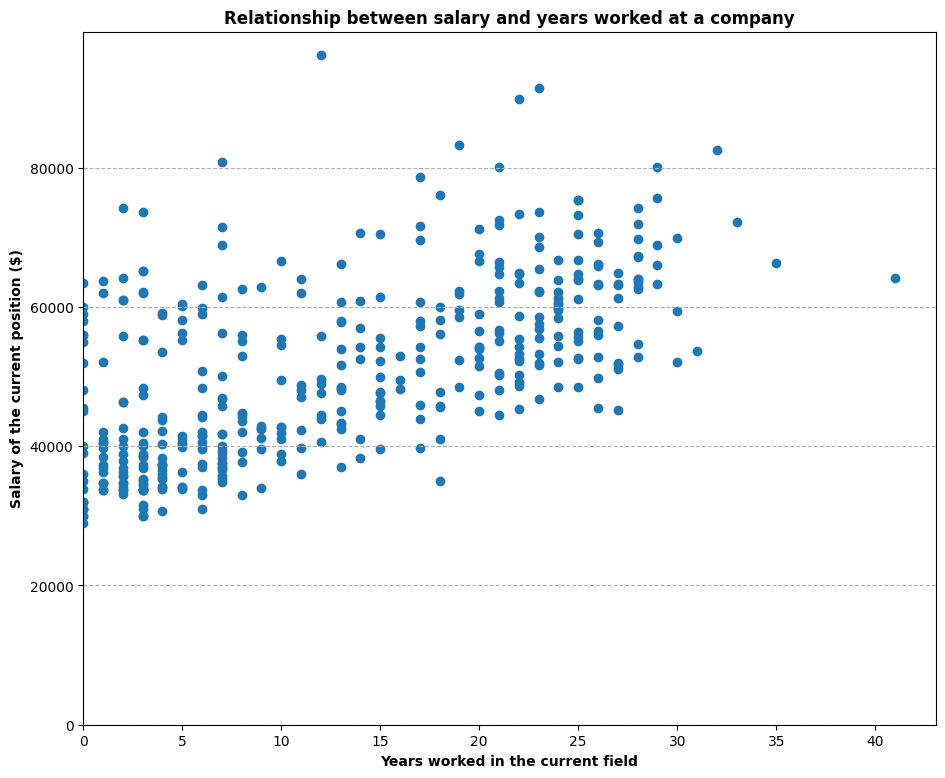

In [15]:
plt.figure(figsize=(11, 9))
plt.scatter(X_train['years worked in this field'], y_train)

plt.title("Relationship between salary and years worked at a company", fontweight="bold")
plt.xlabel("Years worked in the current field", fontweight="bold")
plt.ylabel("Salary of the current position ($)", fontweight="bold")
plt.grid(axis='y', linestyle='--')
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.show()

The scatter plot reveals a linear relationship between the salary paid and the number of years worked that is positive. This indicates that the simple linear regression model is a suitable model to use.

The next step is observing the distributions of all the columns. To make the code DRY a function will be used that plots the histogram for each column

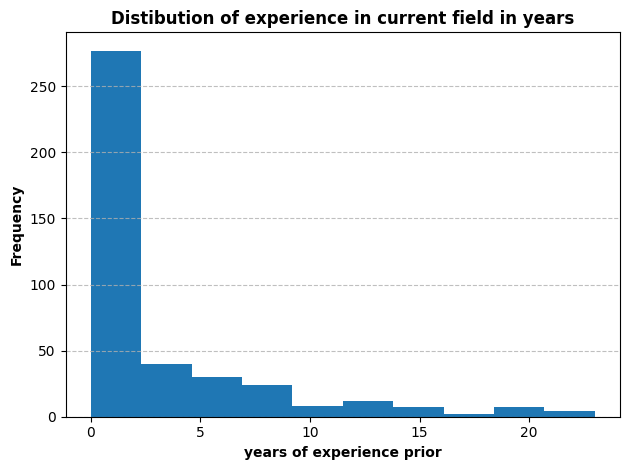

In [16]:
def histogram_plot(column_name, title ):
    plt.hist(X_train[column_name])
    
    plt.title(title, fontweight='bold')
    plt.xlabel(column_name, fontweight='bold')
    plt.ylabel("Frequency", fontweight='bold')
    
    
    plt.grid(axis='y', linestyle='--', alpha=0.8)
    plt.tight_layout()
    plt.show()

histogram_plot("years of experience prior", "Distibution of experience in current field in years")

The plot indicates that the distribution is skewed to the right with more than 250 people indicating that they have 0-2.5 years of experience followed by 2.5-5 years for 50 people followed by 5-7.5 years with slightly less than 50 people. After this, there is a sharp decrease in response from 7.5 years onwards. 

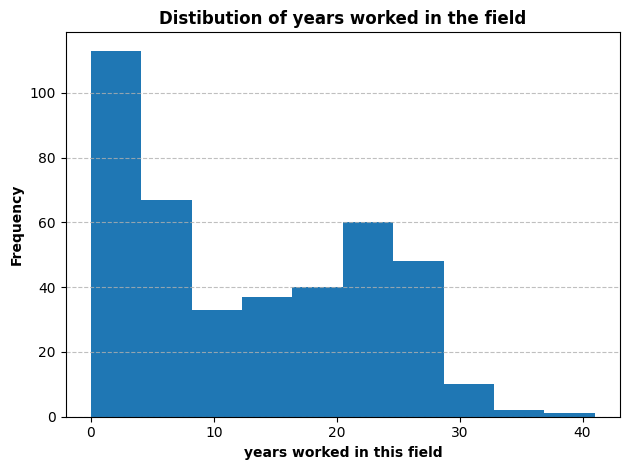

In [17]:
histogram_plot("years worked in this field", "Distibution of years worked in the field")

The distribution is different, unlike the previous one which resembles a normal distribution that is skewed, this one appears to have two peaks with one slightly less than the other. The higher peak for years worked in their specific field is between 0-5 years, with numbers exceeding 100. The second peak is between 20-25 years, which is similar to the years between 5-10. This implies that the highest number of people within the training data spent the least amount of time in their field.

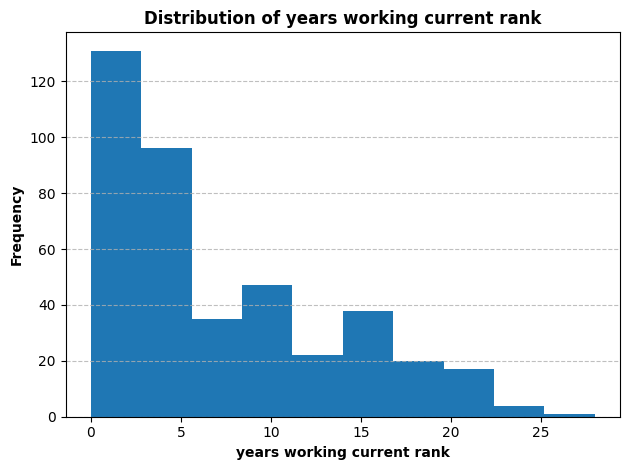

In [18]:
histogram_plot("years working current rank", "Distribution of years working current rank")

The majority of individuals have reported spending less than 5 years in their current rank. Additionally, there is a noticeable decline in the number of individuals as the number of years worked increases. This trend suggests that individuals do not tend to remain in the same rank for an extended period. They may be promoted, transfer to another department, or for other reasons, do not stay in their current position for an extended duration.

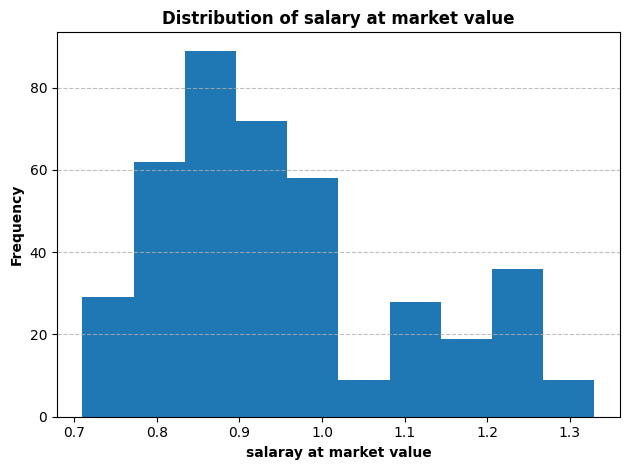

In [19]:
histogram_plot("salaray at market value", "Distribution of salary at market value")

This distribution stands out due to the use of values to assess market value salary. Values less than 1 signify that salaries are below market value, a value of 1 indicates market alignment, and values greater than 1 point to salaries being above market value. Upon examining the distribution, it is evident that the majority of salaries fall below the market value, with very few being paid above market rates.

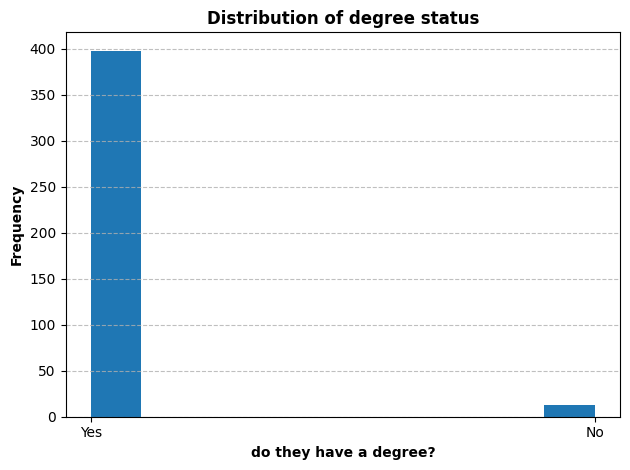

In [20]:
histogram_plot("do they have a degree?", "Distribution of degree status")

This result indicates that out of 411 users, only slightly less than 400 people have degrees with less than 25 people indicating that they do not have.

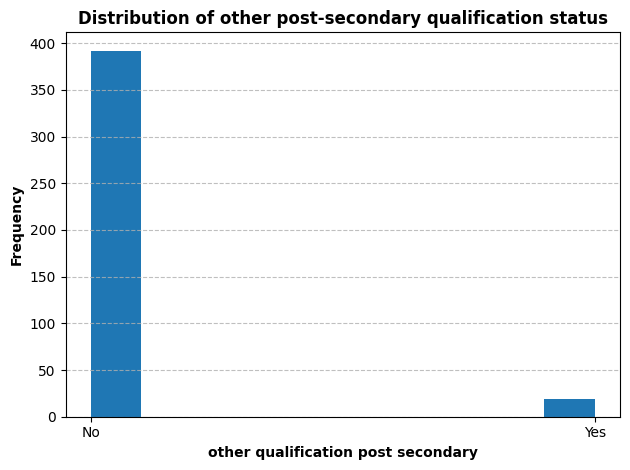

In [21]:
histogram_plot("other qualification post secondary", "Distribution of other post-secondary qualification status")

The distribution appears to be similar to the one above in terms of shape but is also in direct contrast with the previous one. What can be inferred from this is that all the individuals who indicated that they do not have degrees have some other post-secondary qualification.

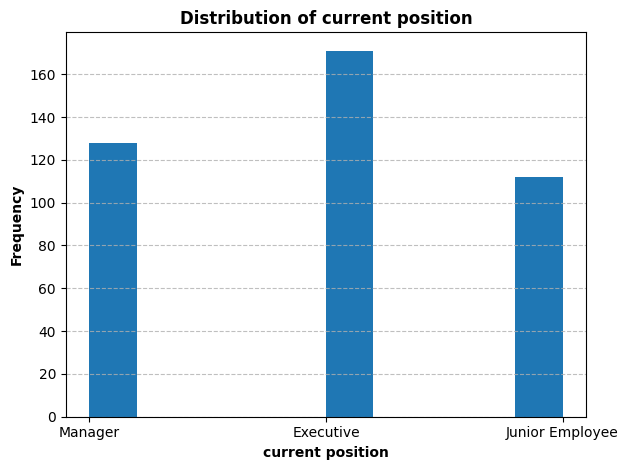

In [22]:
histogram_plot("current position", "Distribution of current position")

This distribution indicates that there are more people at the Executive position, followed by an equal number of Managers and Junior employees

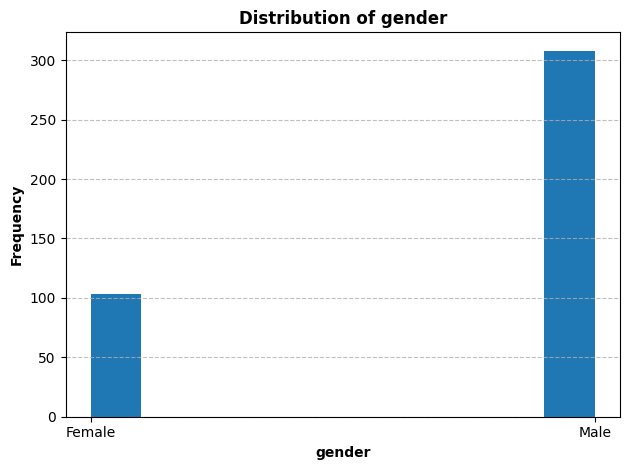

In [23]:
histogram_plot("gender", "Distribution of gender")

This graphs says that there are more male workers than female workers with male workers more than double the number of female workers .

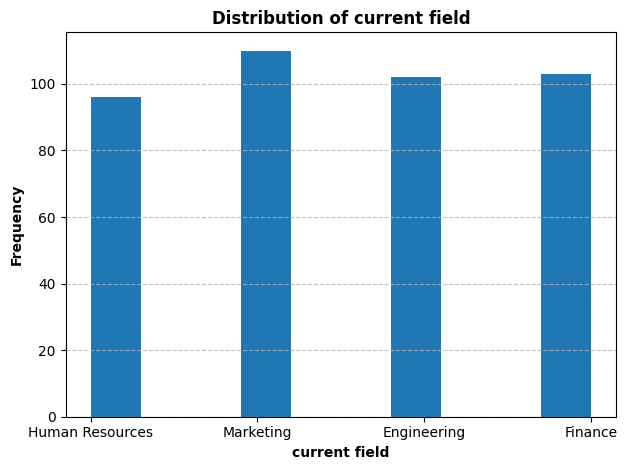

In [24]:
histogram_plot("current field", "Distribution of current field")

When I reviewed the four departments at the company, there were approximately 100 
employees in each department. The Human Resources and Finance departments had over 100 employees each, while the Marketing department had exactly 100 employees, and the Engineering department had slightly fewer than 100 employees.

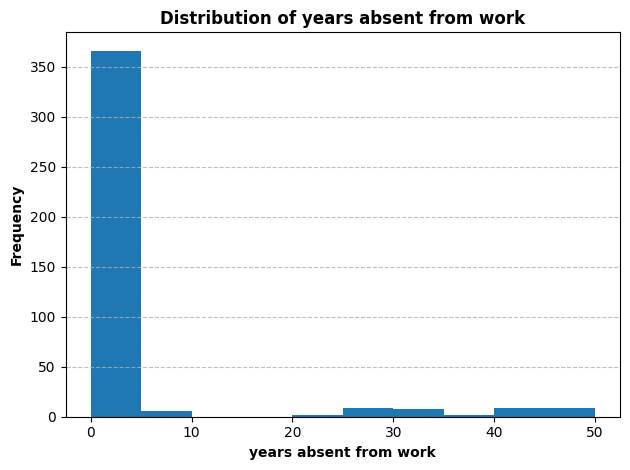

In [25]:
histogram_plot("years absent from work", "Distribution of years absent from work")

The distribution suggests that most individuals in the dataset have not been absent from work, while a small number of individuals have been absent for a very long time, resulting in a highly right-skewed distribution.

## 3. Analysis


### 3.1 Creating the model

The next step is using the training data to build a simple linear regression model

In [26]:
X_indep = X_train["years worked in this field"]
X_indep_constant = sm.add_constant(X_indep)

linear_model = sm.OLS(y_train, X_indep_constant).fit()
linear_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     242.8
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           2.59e-43
Time:                        17:42:10   Log-Likelihood:                -4374.5
No. Observations:                 411   AIC:                             8753.
Df Residuals:                     409   BIC:                             8761.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.034e+04    845.566     47.712      0.000    3.87e+04     4.2e+04
years worked in this field   824.1732     52.888     15.583      0.000     720.207     928.140
==============================================================================
Omnibus:                       69.723   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.798
Skew:                           1.086   Prob(JB):                     1.75e-23
Kurtosis:                       4.183   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model summary indicates a strong positive correlation between salary and the number of years worked in the current field, with an R-squared value of 0.373, signifying that  of the variation in salaries is explained by the years worked. The very small p-value of 2.59e-43 indicates that the model is statistically significant, showing that the relationship between salary and years worked is highly unlikely to be due to chance.

The constant term has a coefficient of approximately \$40 340 (4.034e+04) with an error of \$845,57 and is highly significant (p < 0.001). This represents the base salary when the number of years worked in the field is zero. The unstandardised coefficient for the variable "years worked in this field" is 824.1732, meaning that for each additional year worked in the field, the salary increases by approximately \$824.

The inclusion of the constant term was necessary as it represents the expected salary when the years worked are \$0. Without it, the intercept would be 0, implying that workers who have worked for less than a year would earn \$0, which is unrealistic due to factors like labour laws. The use of a constant also improves the model’s accuracy and provides a better fit for the data.

The confidence interval for the coefficient of "years worked in this field" is [720.207	928.140], indicating that we are 95% confident that the true value of the salary increase for the number of years worked lies within this range.


### 3.2 Using the model to predict values

The following prediction is for a worker who has worked in their current field for 12 years

In [27]:
worked_12_years_df = pd.DataFrame({'const': 1, 'years worked in this field': 12}, index=[0])


predicted_salary_12 = linear_model.predict(worked_12_years_df)
predicted_salary_12[0]

50233.36887367738

The model predicts that for an individual who has been working for 12 years should earn a salary of $50 223,369. The next prediction is for a worker who has worked for 80 years

In [28]:
worked_80_years_df  = pd.DataFrame({'const': 1, 'years worked in this field': 80}, index=[0])

predicted_salary_80 = linear_model.predict(worked_80_years_df)
predicted_salary_80[0]

106277.14956000468

The model's prediction indicates that an individual who has been working for 80 years should earn a salary of $106 277,15. However, this prediction is not entirely accurate. The model used the column `years worked in this field`, which was validated to ensure that the number of years worked was realistic at less than 50. Therefore, the data was extrapolated outside the range of the training data. The issue with this prediction is that the model lacks a basis for understanding how the relationship works beyond the limits of the training data. Furthermore, the relationship beyond 50 years might not be linear, as the age may increase linearly but the salary increase might shift based on realistic factors. As a result, this prediction is statistically dubious and practically irrelevant.

### 3.3 Fitting the model to the test set

Earlier in the notebook the dataframe `salary_df` was split into 2, training data and test data. Using the training data a linear model was built. The next part will see the model being fit to the test data and observing the results

In [29]:
X_test_indep = X_test["yearsworked"]
X_test_const = sm.add_constant(X_test_indep)

predicted_salaries_test = linear_model.predict(X_test_const)
predicted_salaries_test.head()

25     42815.809665
371    58475.101328
362    63420.140800
242    58475.101328
232    56002.581591
dtype: float64

The model was fitted with the test set data and the dataframe consisting of the predicted salaries was obtained.

### 3.4 Comparing the model

To compare the model and observe the presence of overfitting, the root mean square for both the test and training data is calculated to see what insights can be derived from them 

In [30]:
predicted_salaries_train  = linear_model.predict(X_indep_constant)

rmse_train = np.sqrt(mean_squared_error(y_train, predicted_salaries_train))
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_salaries_test))

print(f"The Root-Mean Squared error for the training set data is: {rmse_train}")
print(f"The Root-Mean Squared error for the test set data is: {rmse_test}")

The Root-Mean Squared error for the training set data is: 10144.081736603812
The Root-Mean Squared error for the test set data is: 8877.878490889048


The Root Mean Squared Error (RMSE) for the training set is 10144.08, and for the test set, it is 8877.88. These results indicate that the model performs reasonably well on both datasets, with predictions closely aligned with actual salaries. The RMSE values suggest that the model has a slightly higher error on the training set compared to the test set. This is unusual but not necessarily problematic.

The difference between these RMSE values (10144.08 - 8877.88 = 1266.20) suggests some variation, but it is not substantial enough to indicate severe overfitting. In fact, it may hint at a few possibilities:
There could be more noise or outliers in the training data compared to the test data or the model might be regularized in a way that causes it to perform better on the test data.

Overall, the model shows good generalization to the unseen data, demonstrating strong predictive performance without clear evidence of overfitting. However, it is essential to review the data and model training process to ensure that the results are reliable and to understand the cause of the observed difference in RMSE values.

### 3.5 Other Features Influencing Salary

The number of years worked is not the only factor that can influence the salary a worker is paid; other factors are also present in the training dataset. These factors include years of experience prior to the current job, years working at the current rank, salary at market value, whether or not they have a degree or other post-secondary qualifications, the field they are employed in, the number of years they were absent from work, and, unfortunately, gender.

Including all these features in the model, assuming they are independent of each other, could make the model more reliable by providing a better understanding of the various factors that determine salary. However, with this better understanding comes the risk of overfitting. While adding more variables might increase the R-squared value, indicating that a higher proportion of variance in the dependent variable is explained by the model, it does not necessarily mean the model is better. Overfitting occurs when the model becomes too complex and starts capturing noise in the data rather than the true underlying patterns. Therefore, it's essential to balance the complexity of the model with its ability to generalize to new, unseen data.

## 4. Conclusion

The main goal of this project was to create a linear model that could predict salaries within a company using a given dataset. Before building the model, the dataset went through preprocessing, including an 80-20 split into training and test data, cleaning, and validation procedures. Most of the work was done on the training data, where thorough checks were conducted for missing values and data integrity before building an Ordinary Least Squares model.

The model summary revealed an R-squared value of 0.373, indicating that approximately 37.3% of the variance in salaries can be explained by the number of years worked. This relationship was statistically significant, bolstering confidence in the model's reliability. Additionally, the inclusion of a constant term in the model accounted for the dependent variable when the feature is 0, enhancing its accuracy.

After fitting the model to the test data and comparing the results with RMSE values, the minor discrepancy between the two values suggested minimal risk of overfitting. This outcome indicates that the model performed adequately on both the training and test sets, underscoring its utility and robustness in predicting salaries within the company.

Going forward, further improvements and extensions to the model could involve incorporating additional features and exploring advanced regression techniques to enhance predictive capabilities. Additionally, ongoing efforts to address potential biases, such as gender disparities, and promote transparency in salary determination processes are essential for fostering an equitable and inclusive work environment.

In conclusion, this project demonstrates the effectiveness of a data-driven approach in understanding and predicting salary dynamics within organizations, offering valuable insights for optimizing workforce management and promoting fairness and accountability in salary allocation practices.
